# Surprise Housing Assignment

### The solution is divided into the following sections:

- Reading and Understanding the Data
- Data Visualisation
- Missing Value Treatment
- Data Preparation
- Building Model
- Model Evaluation

### 1. Reading and Understanding the Data

In [1]:
##Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the dataset
housing = pd.read_csv('https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv')

In [3]:
housing.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

housing.info()

###### Looking at the data types of all columns and comparing them with the data description of each columns, we deduce that the types of following columns have to be changed:
Columns MSSubClass, OverallQual, OverallCond need to be converted to object type

In [4]:
## Convert three columns to 'object' type as mentioned above
housing[['MSSubClass', 'OverallQual', 'OverallCond']] = housing[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')

In [5]:
#drop columns with max null values
housing = housing.drop(['Id','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1)

In [6]:
#data cleaning, fill missing values

housing['LotFrontage'].fillna(housing['LotFrontage'].median(), inplace=True)
housing['MasVnrArea'].fillna(housing['MasVnrArea'].median(), inplace=True)
housing['GarageYrBlt'].fillna(housing['GarageYrBlt'].median(), inplace=True)
housing['MasVnrType'].fillna('None', inplace=True)


columns_to_fill_with_mode = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType1', 'BsmtFinType2','Electrical','GarageType','GarageFinish','GarageQual','BsmtCond','GarageCond']

# Iterate through the selected columns and replace missing values with mode
for col in columns_to_fill_with_mode:
    mode_value = housing[col].mode().iloc[0]  # Calculate mode for the column
    housing[col].fillna(mode_value, inplace=True)  # Replace missing values with mode
    

missing_values = housing.isna()  # or df.isnull()
columns_with_missing_values = housing.columns[missing_values.any()]
columns_df = housing[columns_with_missing_values]

columns_df.isna().sum()

Series([], dtype: float64)

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   object 
 16  OverallCond    1460 non-null   object 
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [8]:
#Categorize the columns based on data type:

numeric_columns = housing.select_dtypes(include=[np.number]).columns
categorical_columns = housing.select_dtypes(include=[np.object, 'category']).columns



In [9]:
from scipy.stats import chi2_contingency

numeric_correlation_matrix = housing[numeric_columns].corr()

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        categorical_correlation_matrix.loc[col1, col2] = cramers_v(housing[col1], housing[col2])
        
print("Numeric Correlation Matrix:")
print(numeric_correlation_matrix)

print("\nCategorical Correlation Matrix (Cramer's V):")
print(categorical_correlation_matrix)


        

Numeric Correlation Matrix:
               LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
LotFrontage       1.000000  0.304522   0.116685      0.083348    0.178469   
LotArea           0.304522  1.000000   0.014228      0.013788    0.103321   
YearBuilt         0.116685  0.014228   1.000000      0.592855    0.311600   
YearRemodAdd      0.083348  0.013788   0.592855      1.000000    0.176529   
MasVnrArea        0.178469  0.103321   0.311600      0.176529    1.000000   
BsmtFinSF1        0.214367  0.214103   0.249503      0.128451    0.261256   
BsmtFinSF2        0.042463  0.111170  -0.049107     -0.067759   -0.071330   
BsmtUnfSF         0.124098 -0.002618   0.149040      0.181133    0.113862   
TotalBsmtSF       0.363472  0.260833   0.391452      0.291066    0.360067   
1stFlrSF          0.413773  0.299475   0.281986      0.240379    0.339850   
2ndFlrSF          0.072388  0.050986   0.010308      0.140024    0.173800   
LowQualFinSF      0.037469  0.004779  -0.183784 

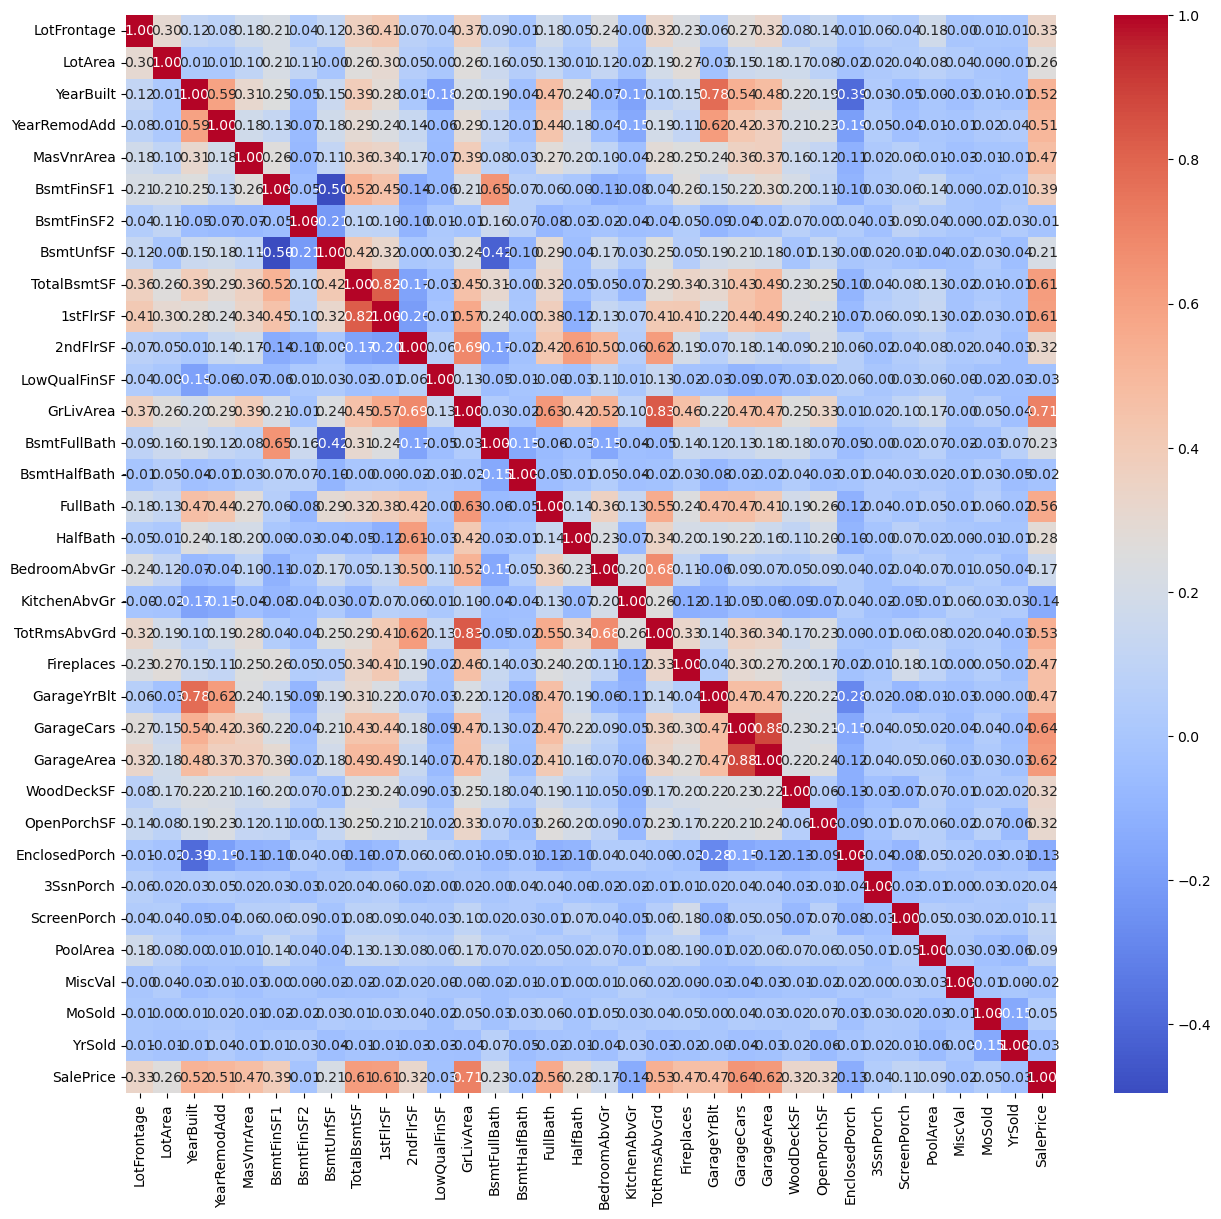

In [10]:
plt.figure(figsize=(15, 14))
sns.heatmap(numeric_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [11]:
# Find highly correlated variables with 'SalePrice'
#threshold = 0.7  # Adjust the threshold
#highly_correlated_variables = numeric_correlation_matrix[abs(numeric_correlation_matrix['SalePrice']) > threshold].index.tolist()

# Remove 'SalePrice' from the list, as it will always have a perfect correlation with itself
#highly_correlated_variables.remove('SalePrice')

# Print highly correlated variables and their correlation coefficients
#print("Highly correlated variables with 'SalePrice' along with their correlation coefficients:")
#for index, row in highly_correlated_variables:
#    if index != 'SalePrice':
#        print(f"{index}: {row['SalePrice']:.2f}")

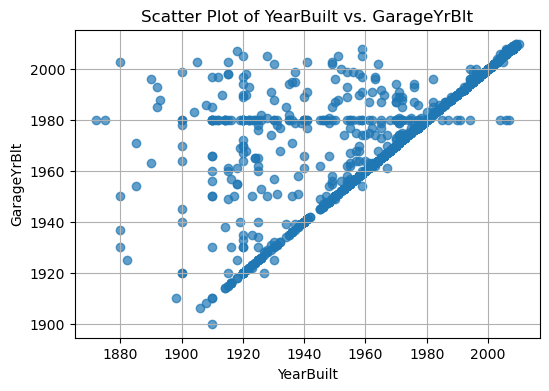

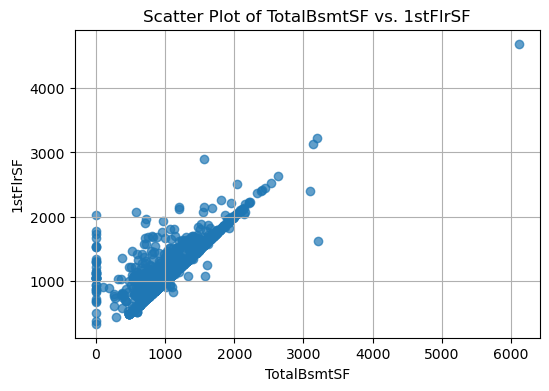

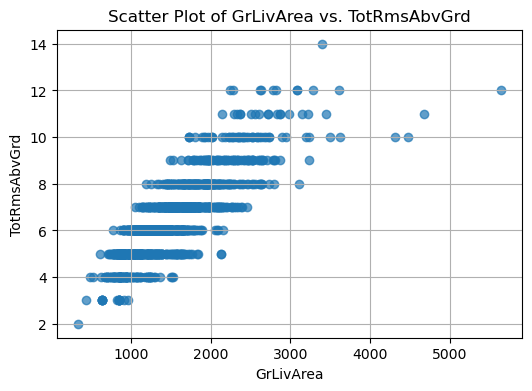

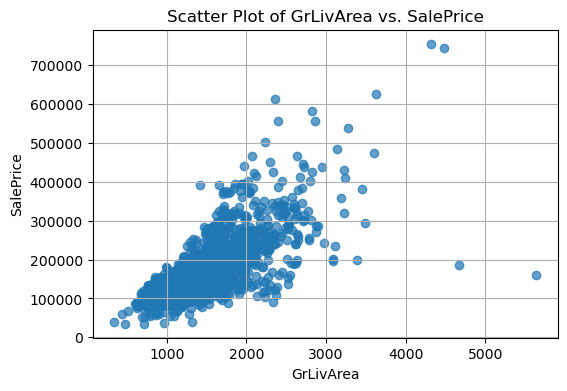

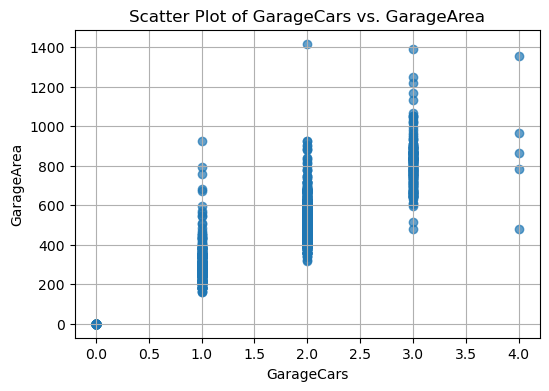

In [12]:
correlation_threshold = 0.7  # Adjust this threshold as needed

highly_correlated_pairs = []

# Find highly correlated variable pairs
for i in range(len(numeric_correlation_matrix.columns)):
    for j in range(i + 1, len(numeric_correlation_matrix.columns)):
        if abs(numeric_correlation_matrix.iloc[i, j]) > correlation_threshold:
            highly_correlated_pairs.append((numeric_correlation_matrix.columns[i], numeric_correlation_matrix.columns[j]))
            

highly_correlated_variables = set()
for pair in highly_correlated_pairs:
    highly_correlated_variables.update(pair)
    
for pair in highly_correlated_pairs:
    var1, var2 = pair
    plt.figure(figsize=(6, 4))
    plt.scatter(housing[var1], housing[var2], alpha=0.7)
    plt.title(f'Scatter Plot of {var1} vs. {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.grid(True)
    plt.show()

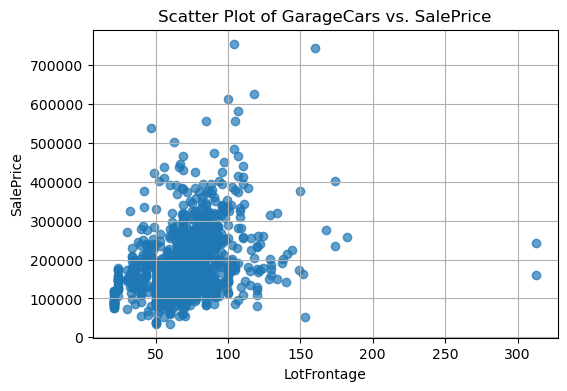

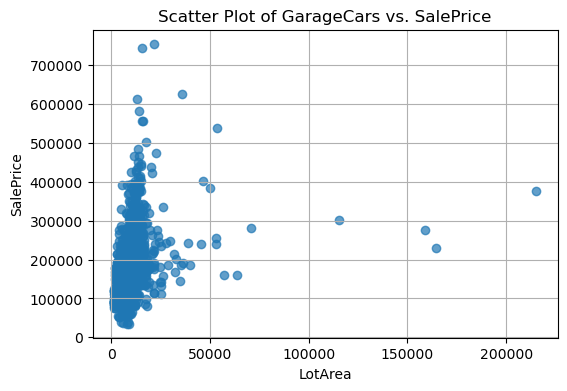

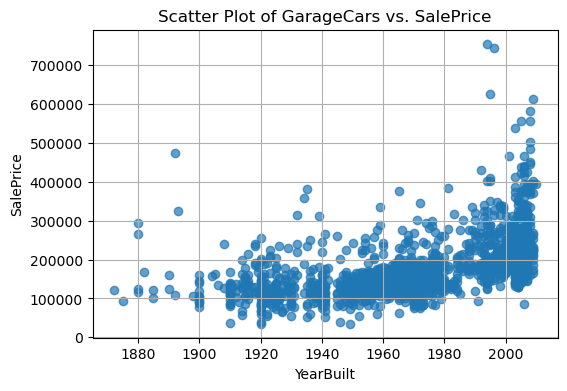

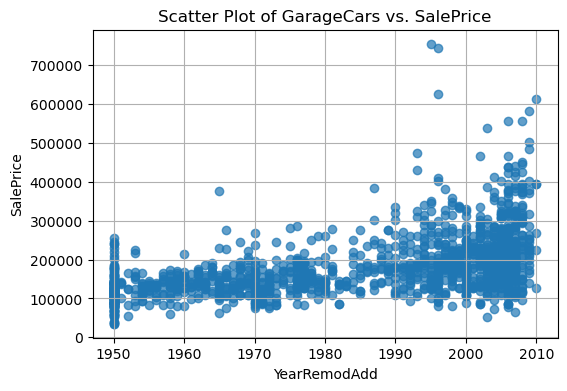

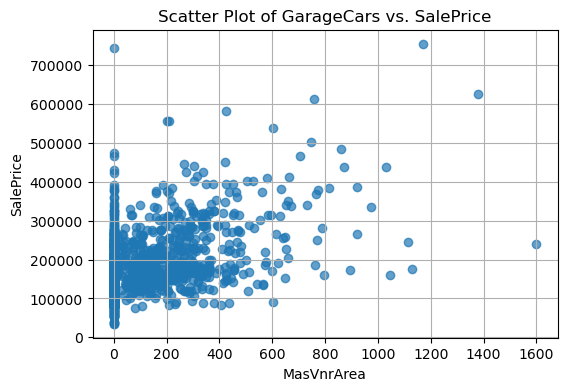

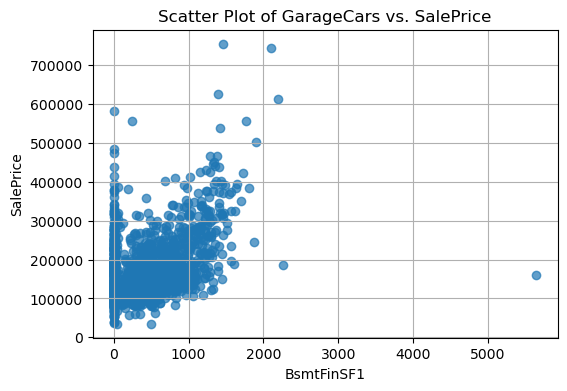

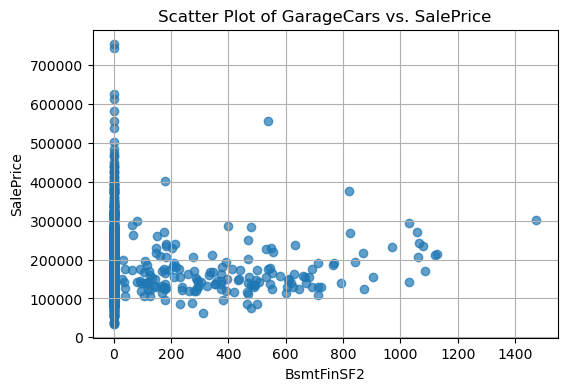

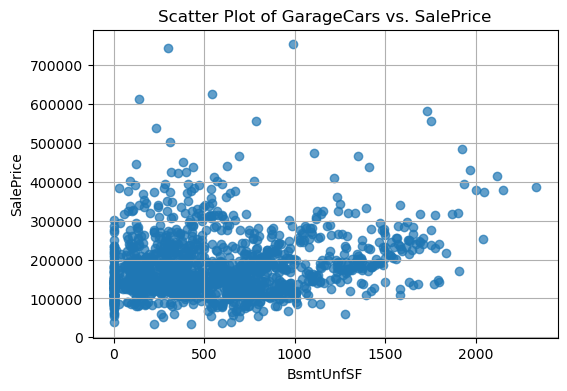

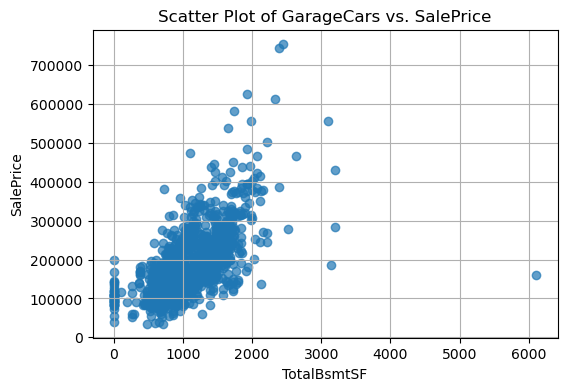

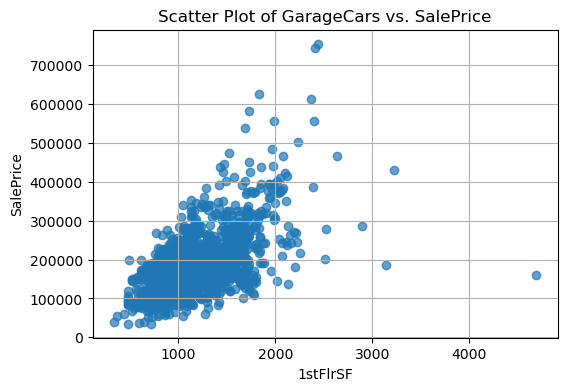

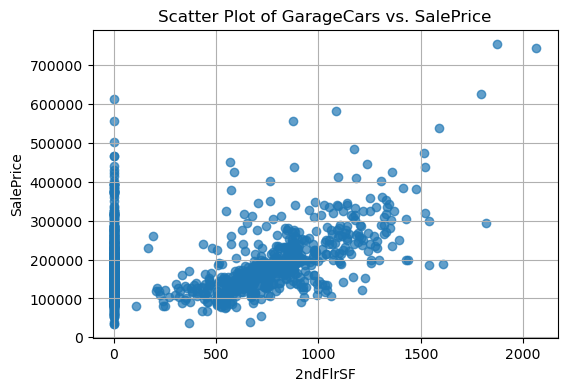

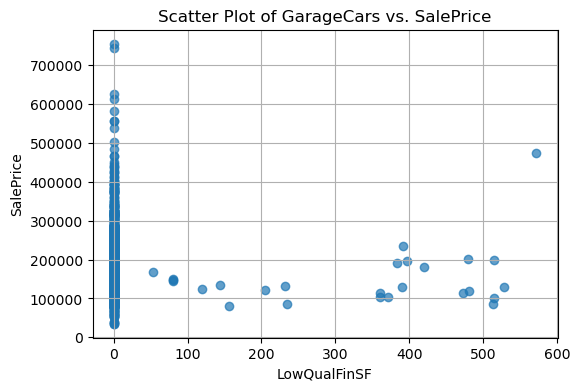

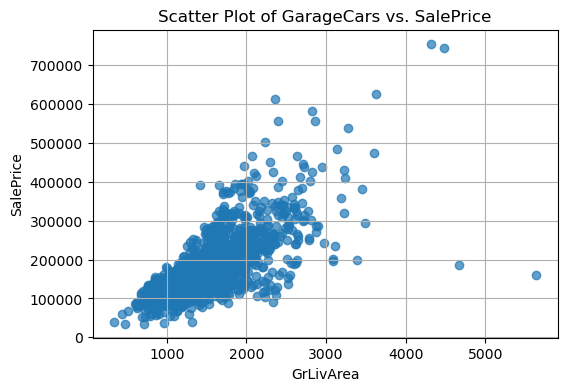

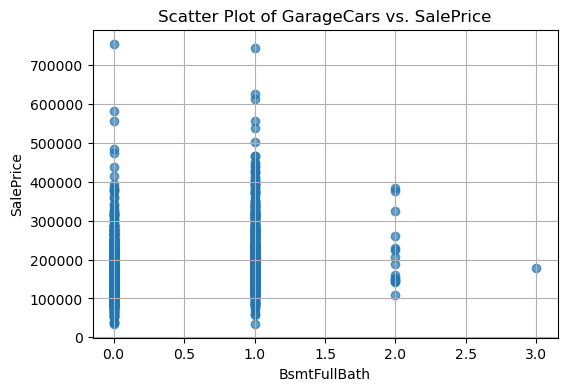

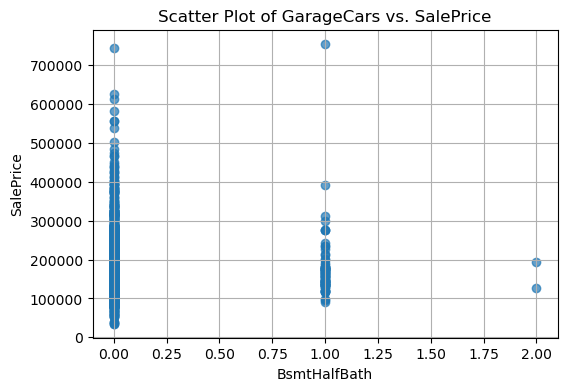

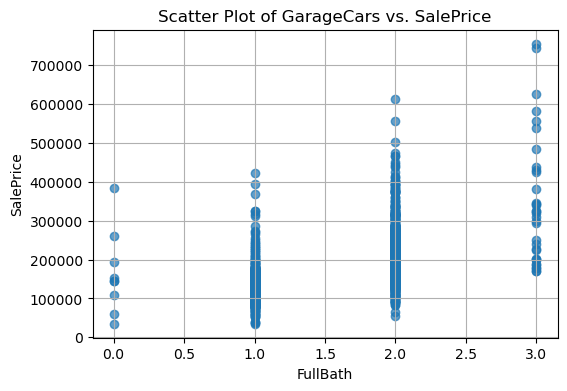

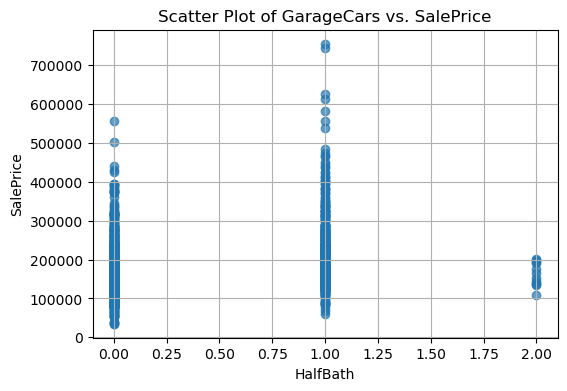

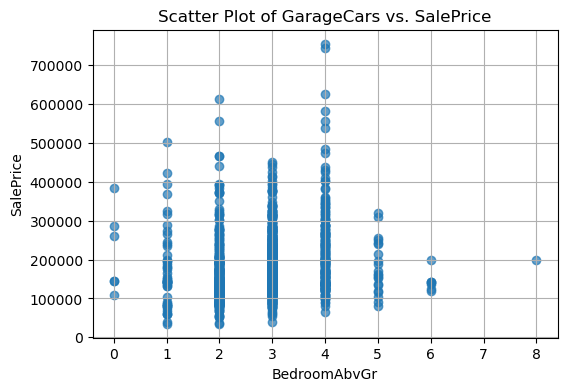

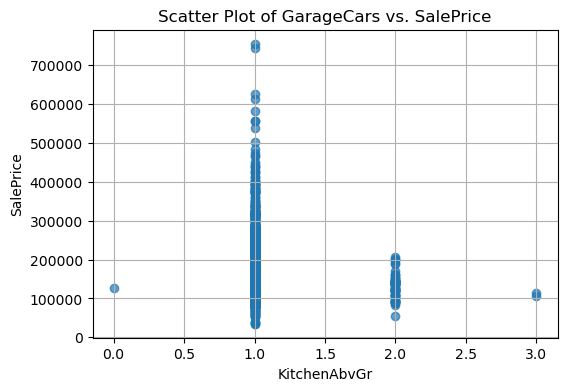

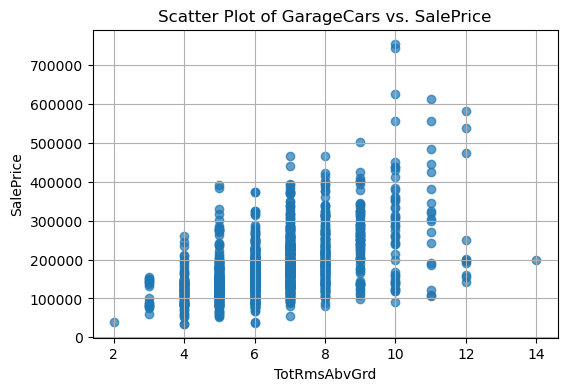

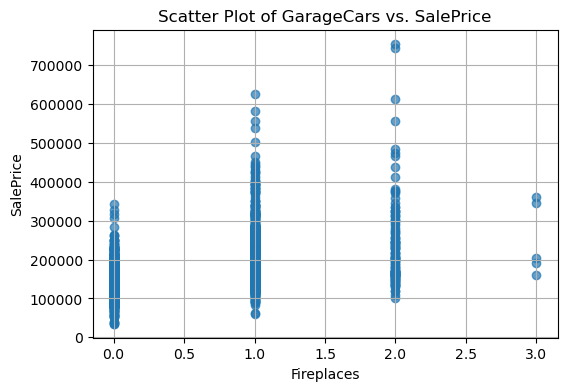

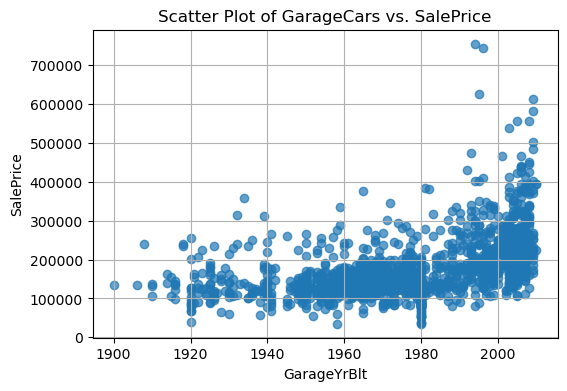

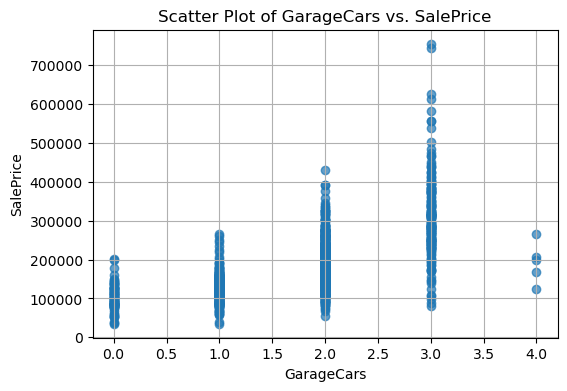

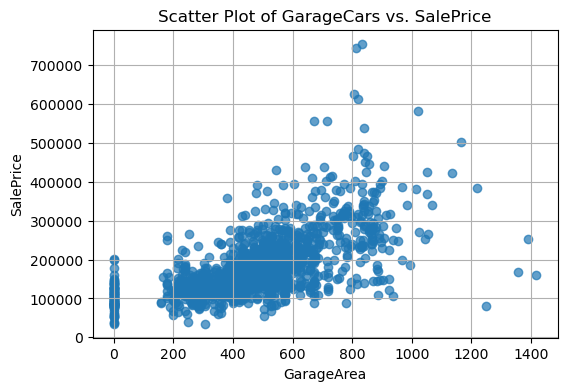

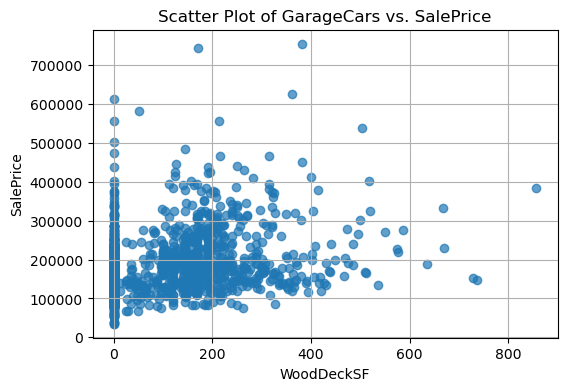

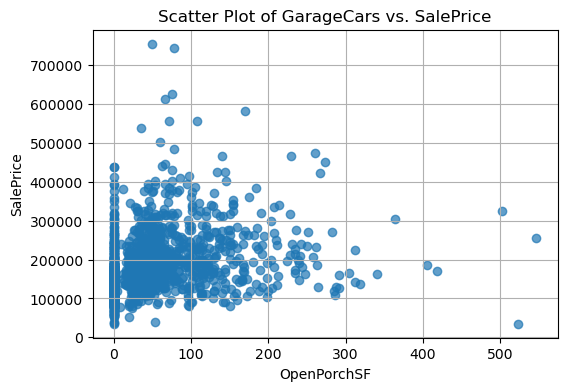

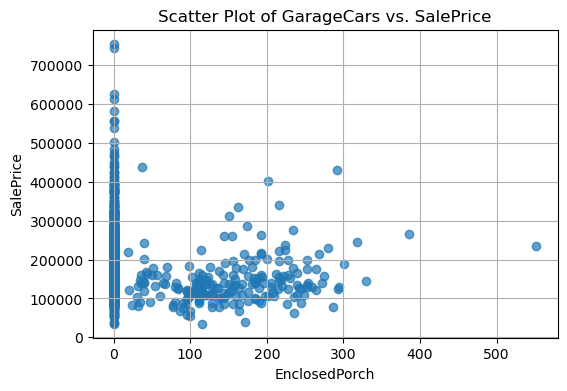

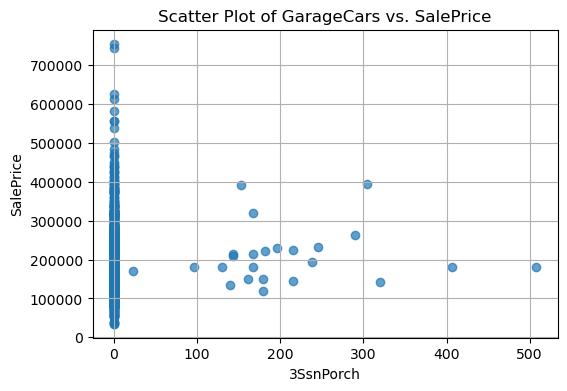

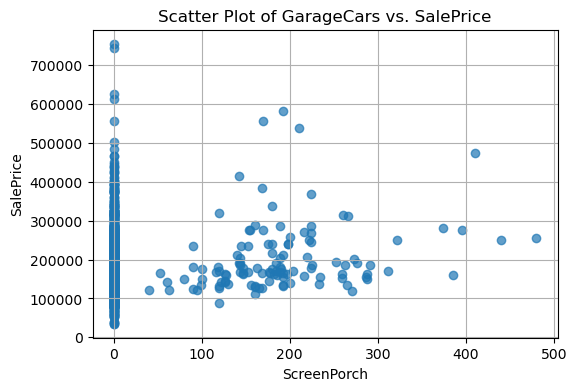

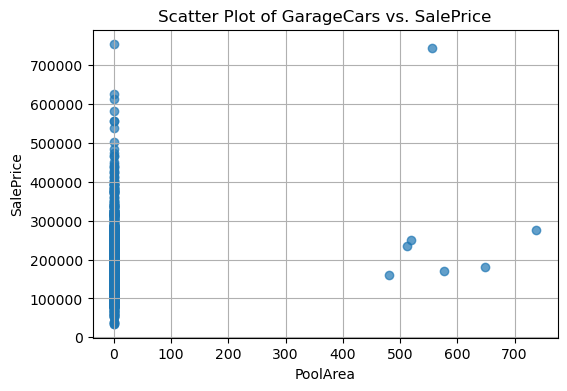

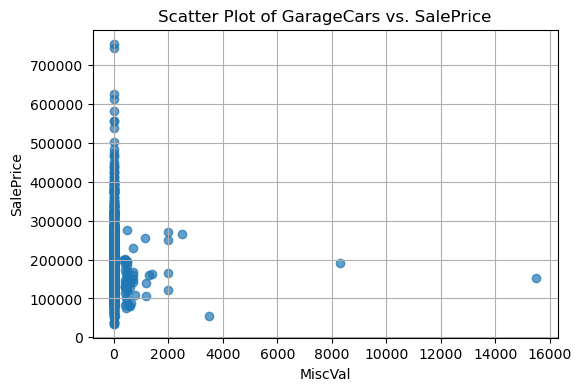

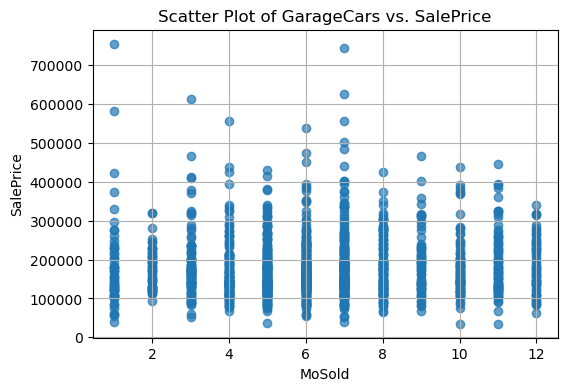

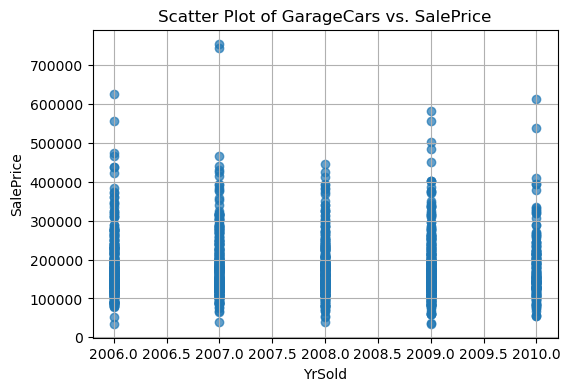

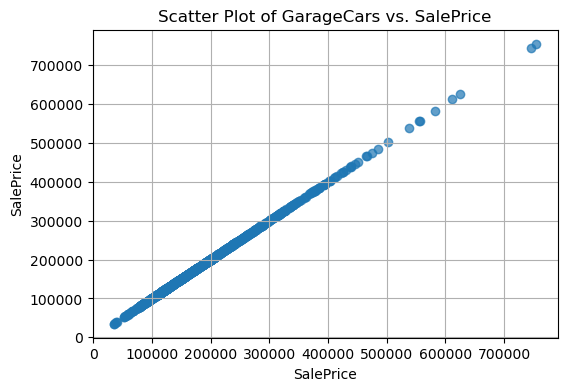

In [13]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(housing[col], housing['SalePrice'], alpha=0.7)
    plt.title(f'Scatter Plot of {var1} vs. SalePrice')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.grid(True)
    plt.show()

# The heatmap shows some useful insights:

Correlation of Saleprice with independent variables:

Price is highly (positively) correlated with LotFrontage, YearBuilt, YearRemodAdd, BsmtFinSF1, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, GrLivArea, Garageyrblt, GarageArea 

Correlation among independent variables:

Many independent variables are highly correlated (look at the top-left part of matrix): wheelbase, carlength, curbweight, enginesize etc. are all measures of 'size/weight', and are positively correlated
Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

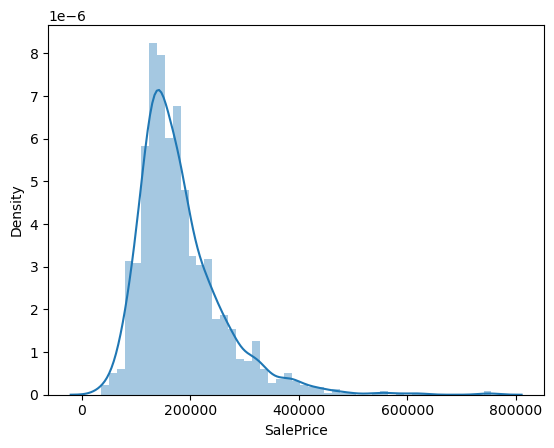

In [14]:
# Target Variable: price of house
sns.distplot(housing['SalePrice'])
plt.show()

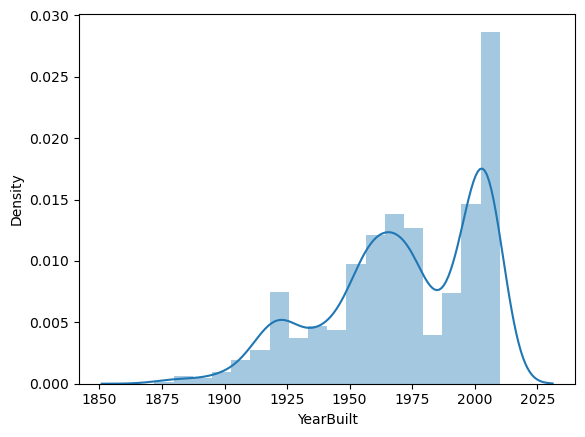

In [15]:
# wheelbase: distance between centre of front and rarewheels
sns.distplot(housing['YearBuilt'])
plt.show()

In [16]:

unique_counts = housing[categorical_columns].nunique()

# Display the counts
print(unique_counts)

MSSubClass       15
MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64


<Figure size 800x600 with 0 Axes>

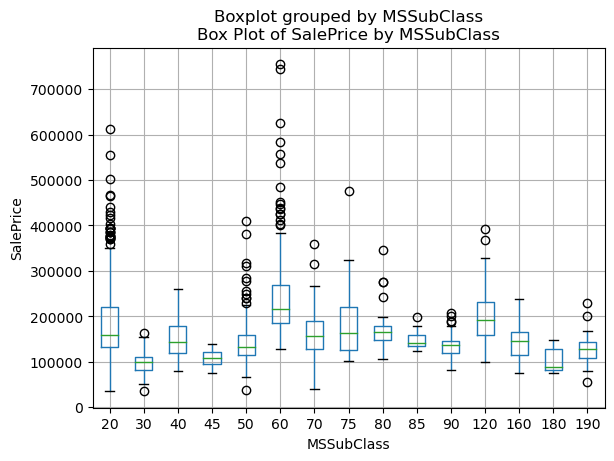

<Figure size 800x600 with 0 Axes>

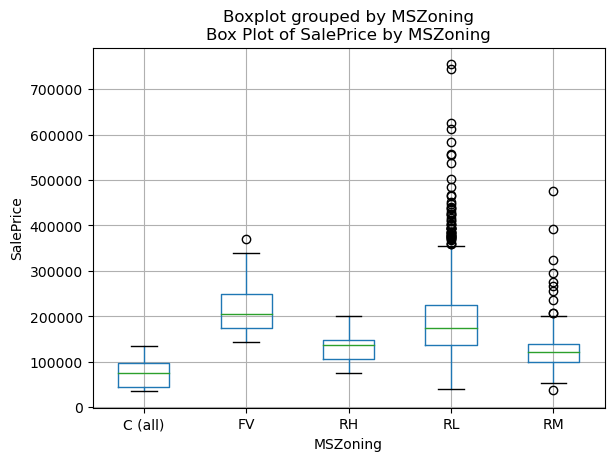

<Figure size 800x600 with 0 Axes>

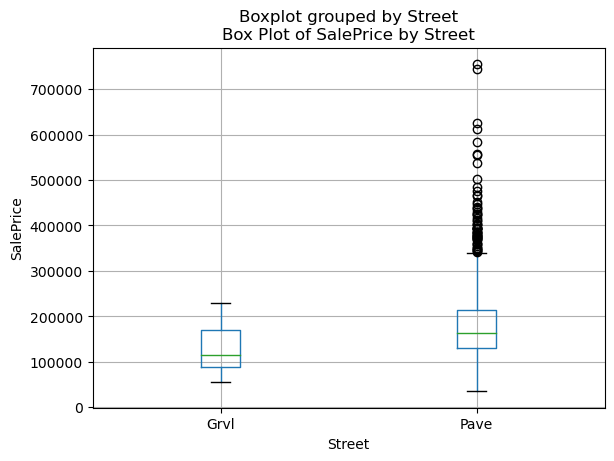

<Figure size 800x600 with 0 Axes>

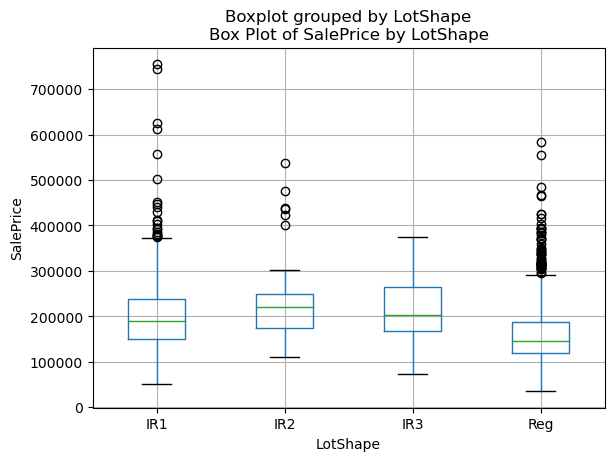

<Figure size 800x600 with 0 Axes>

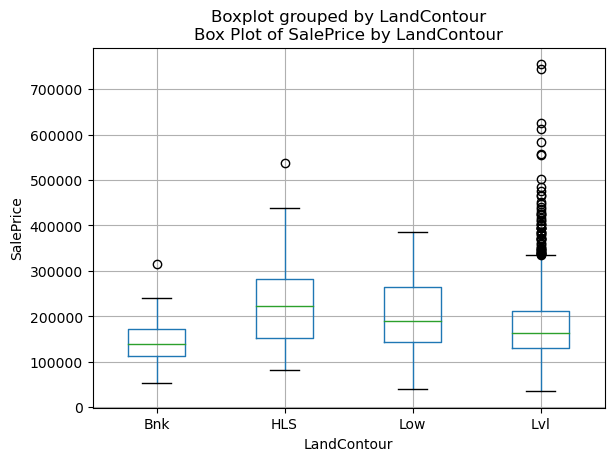

<Figure size 800x600 with 0 Axes>

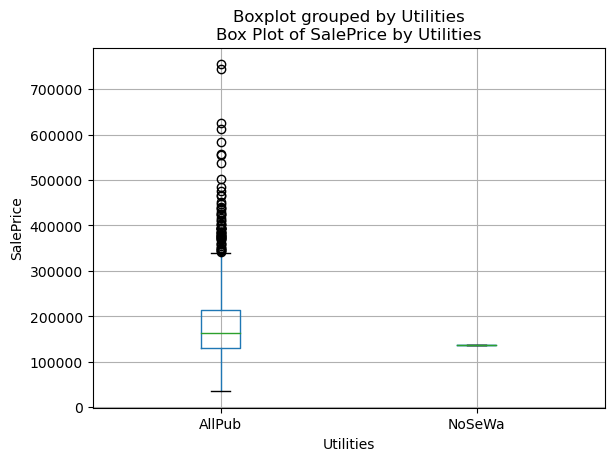

<Figure size 800x600 with 0 Axes>

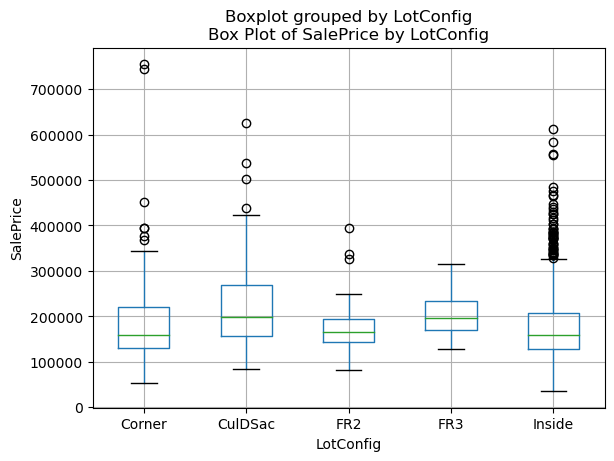

<Figure size 800x600 with 0 Axes>

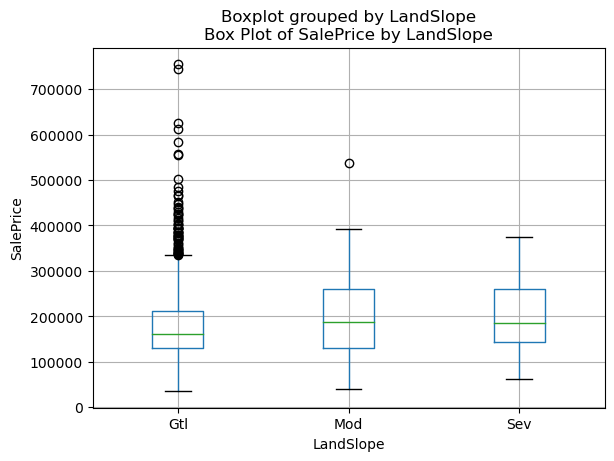

<Figure size 800x600 with 0 Axes>

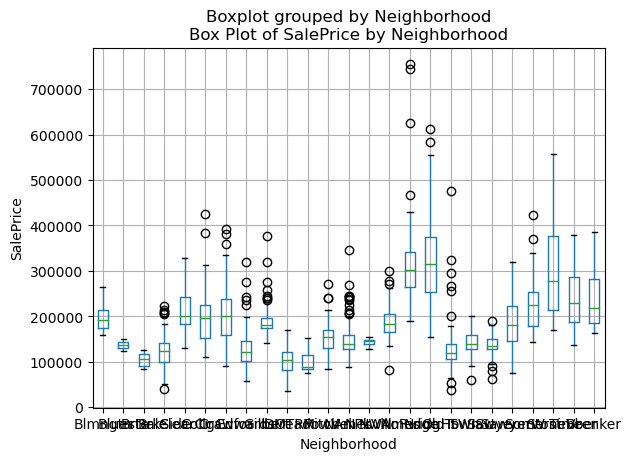

<Figure size 800x600 with 0 Axes>

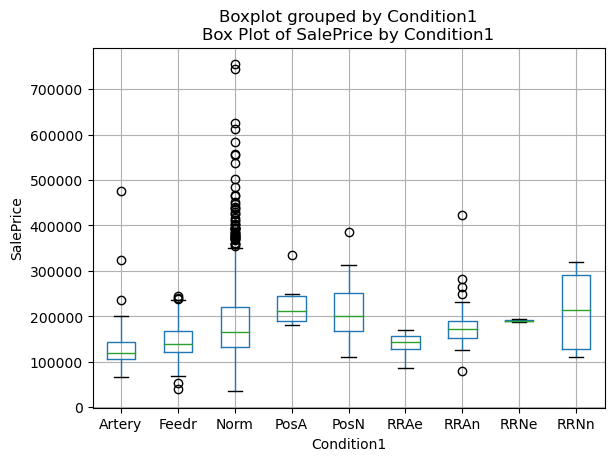

<Figure size 800x600 with 0 Axes>

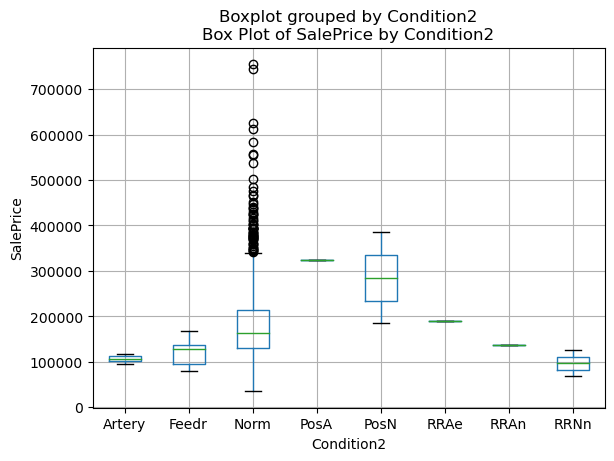

<Figure size 800x600 with 0 Axes>

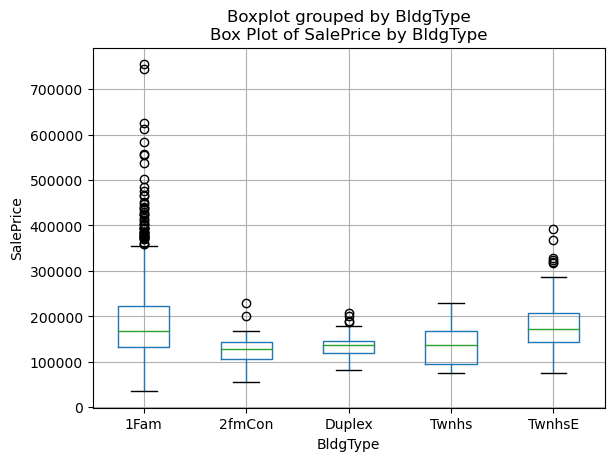

<Figure size 800x600 with 0 Axes>

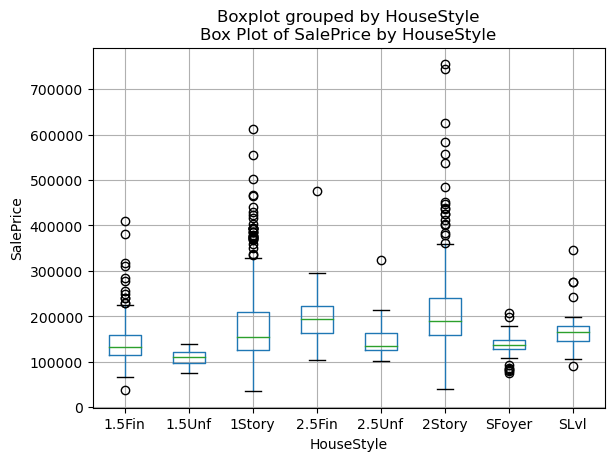

<Figure size 800x600 with 0 Axes>

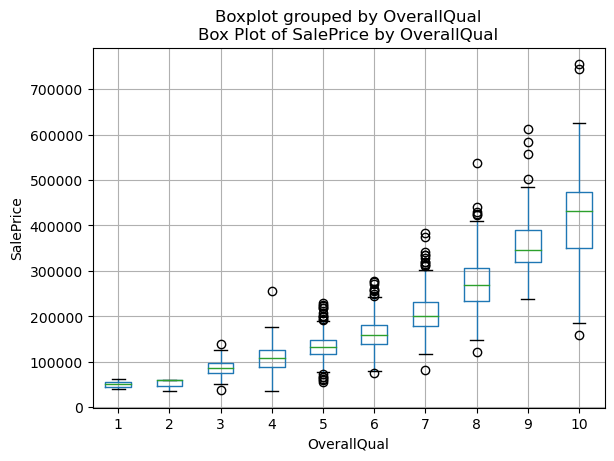

<Figure size 800x600 with 0 Axes>

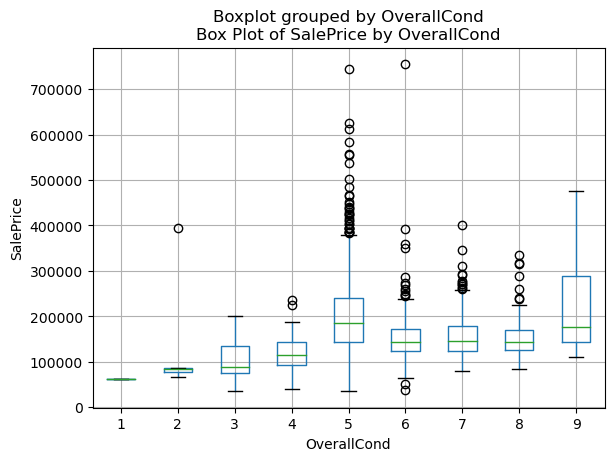

<Figure size 800x600 with 0 Axes>

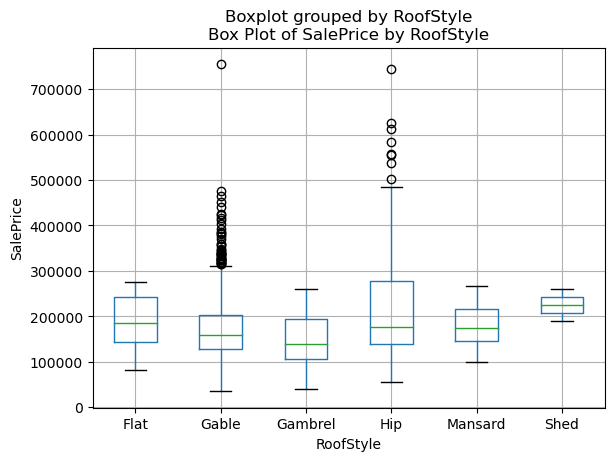

<Figure size 800x600 with 0 Axes>

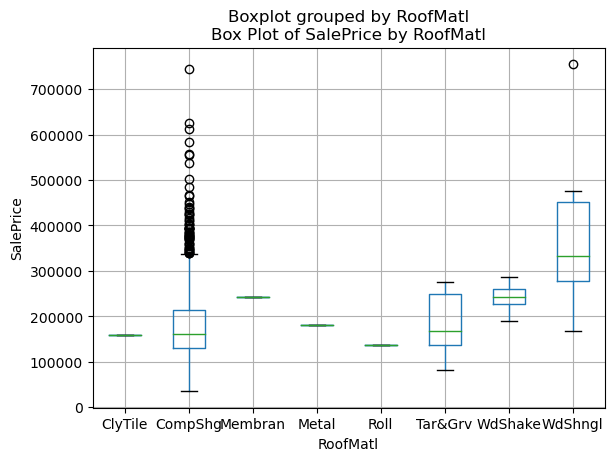

<Figure size 800x600 with 0 Axes>

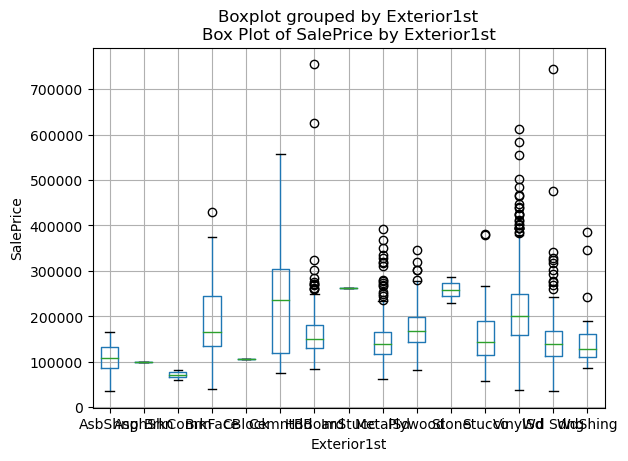

<Figure size 800x600 with 0 Axes>

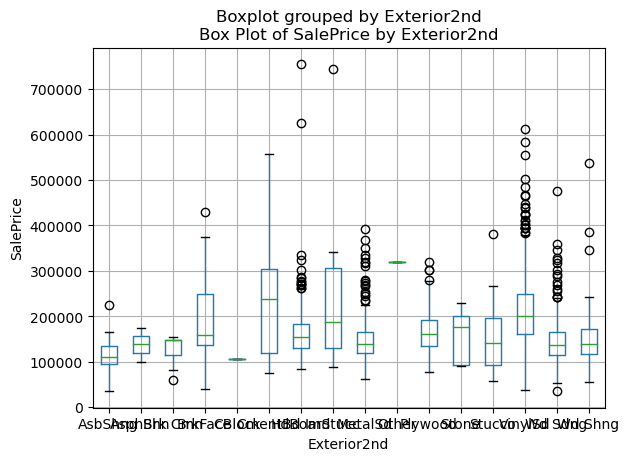

<Figure size 800x600 with 0 Axes>

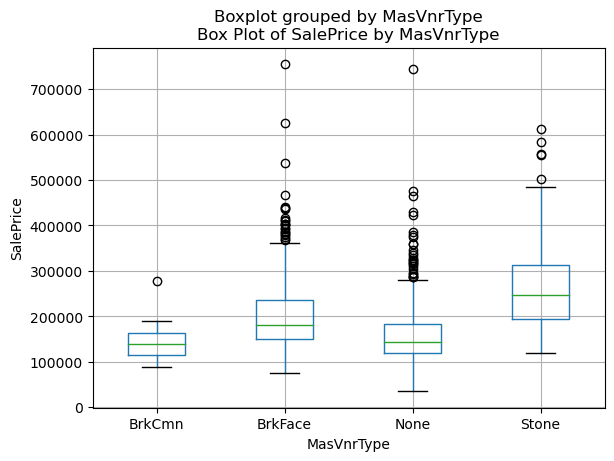

<Figure size 800x600 with 0 Axes>

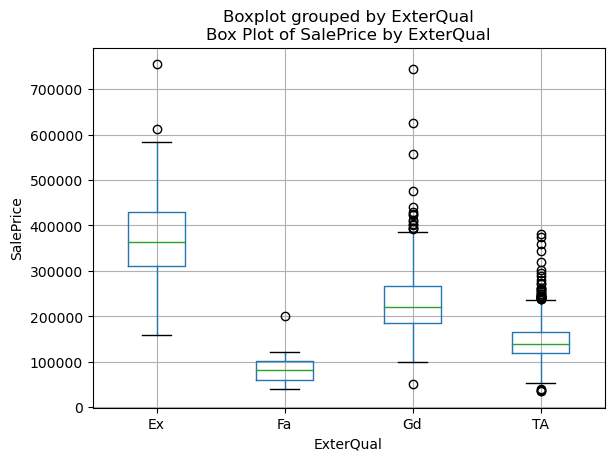

<Figure size 800x600 with 0 Axes>

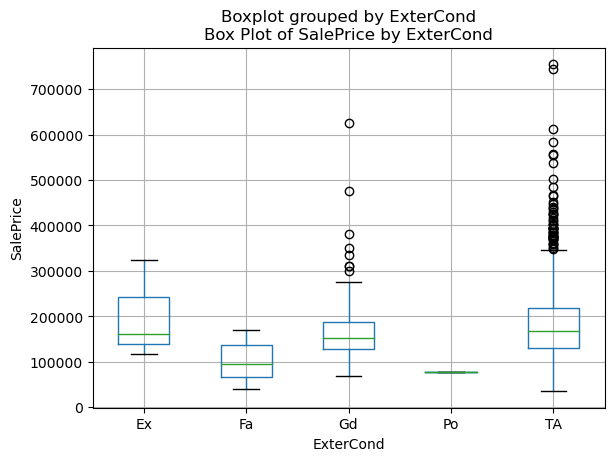

<Figure size 800x600 with 0 Axes>

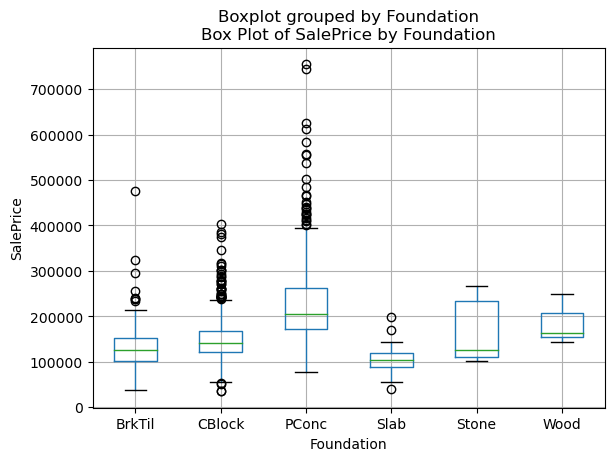

<Figure size 800x600 with 0 Axes>

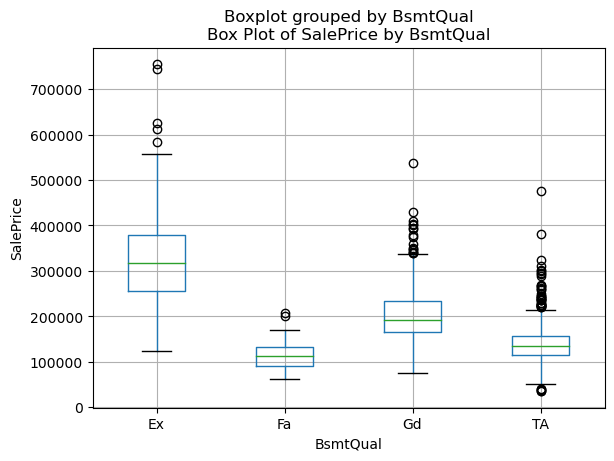

<Figure size 800x600 with 0 Axes>

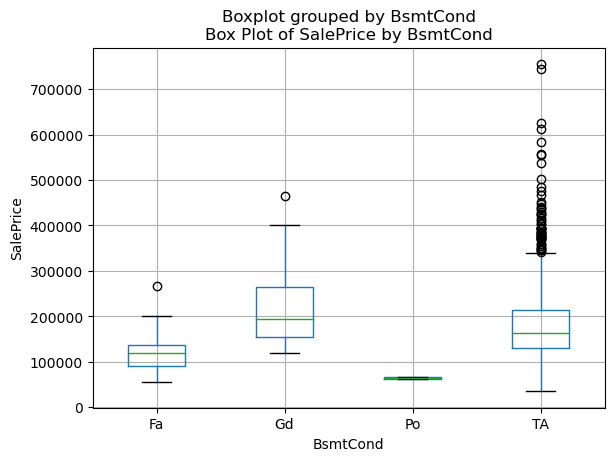

<Figure size 800x600 with 0 Axes>

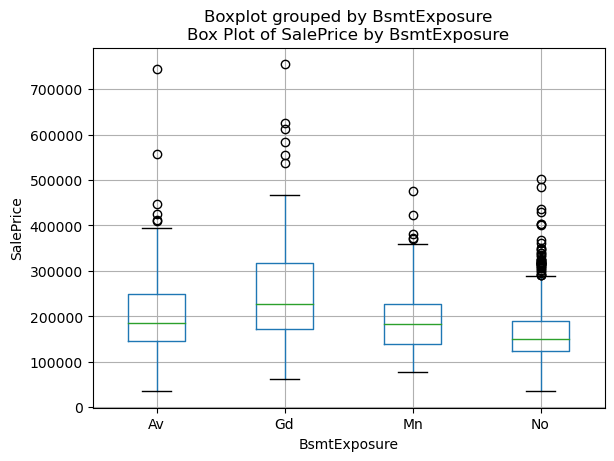

<Figure size 800x600 with 0 Axes>

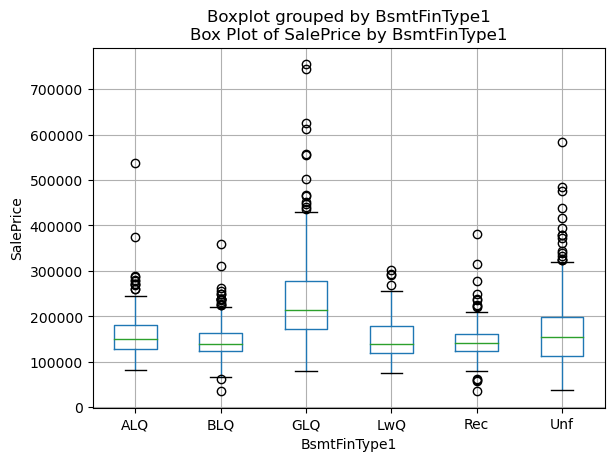

<Figure size 800x600 with 0 Axes>

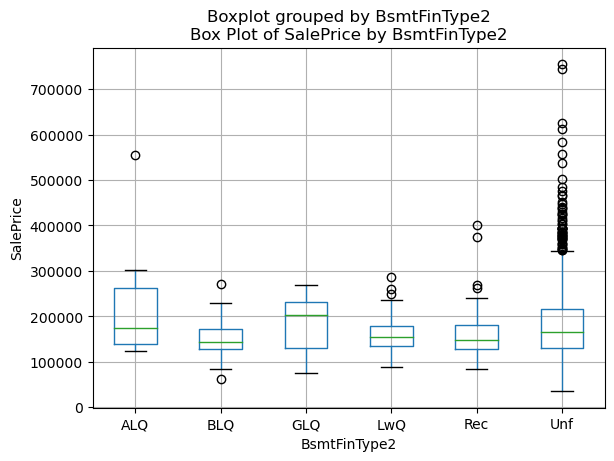

<Figure size 800x600 with 0 Axes>

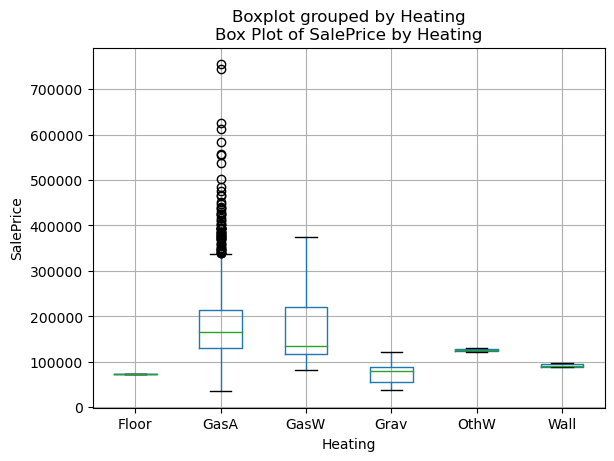

<Figure size 800x600 with 0 Axes>

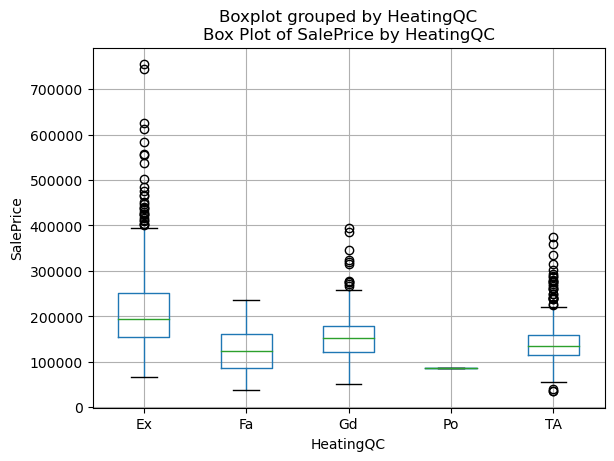

<Figure size 800x600 with 0 Axes>

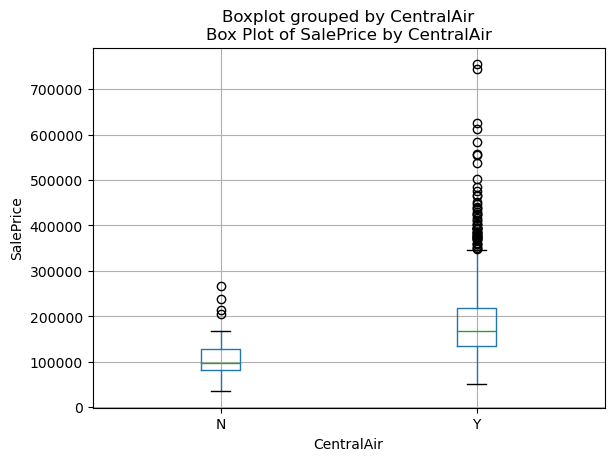

<Figure size 800x600 with 0 Axes>

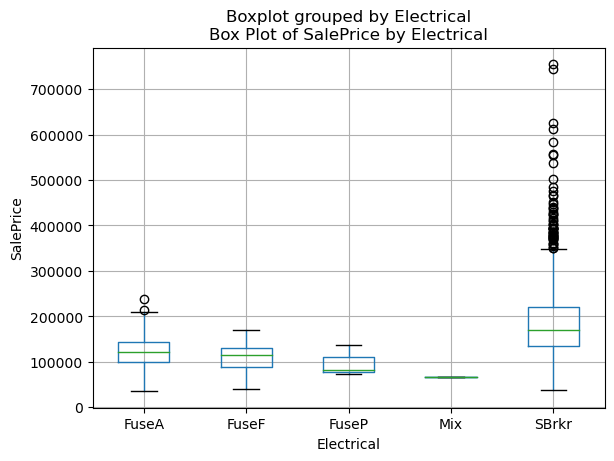

<Figure size 800x600 with 0 Axes>

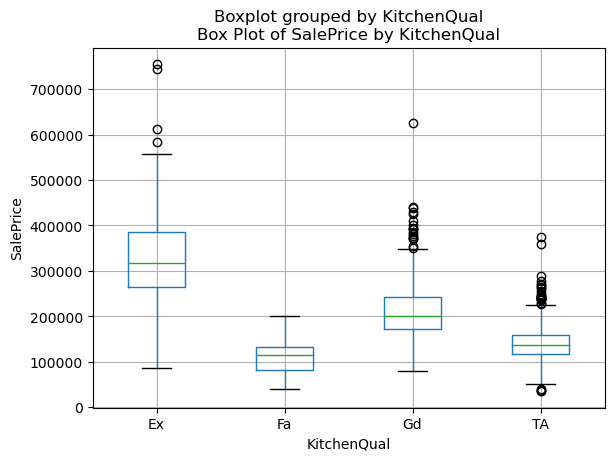

<Figure size 800x600 with 0 Axes>

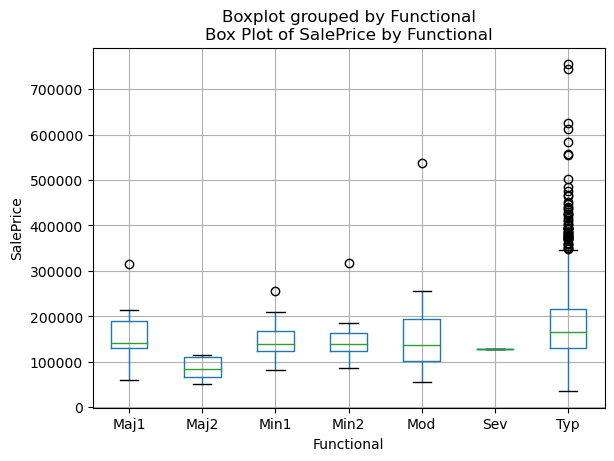

<Figure size 800x600 with 0 Axes>

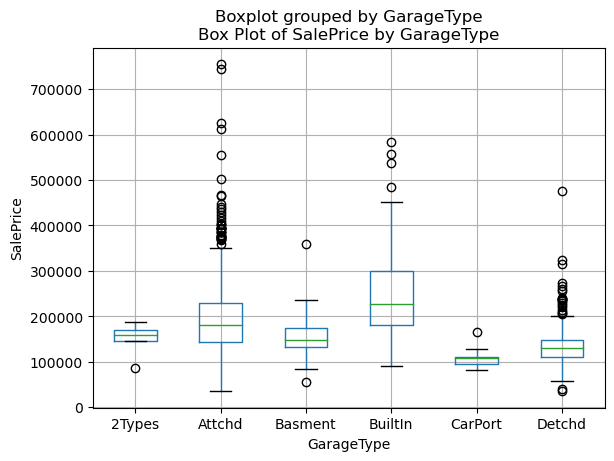

<Figure size 800x600 with 0 Axes>

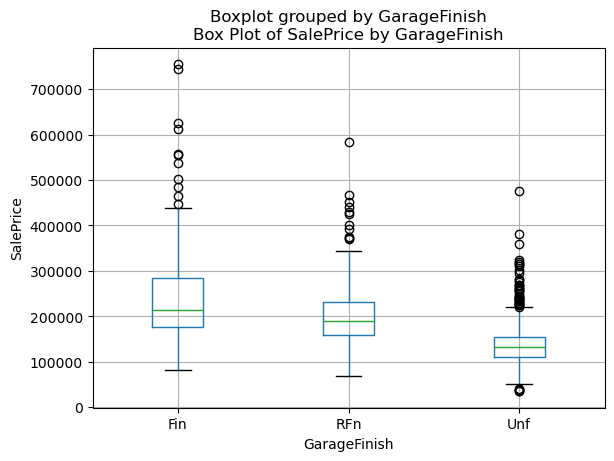

<Figure size 800x600 with 0 Axes>

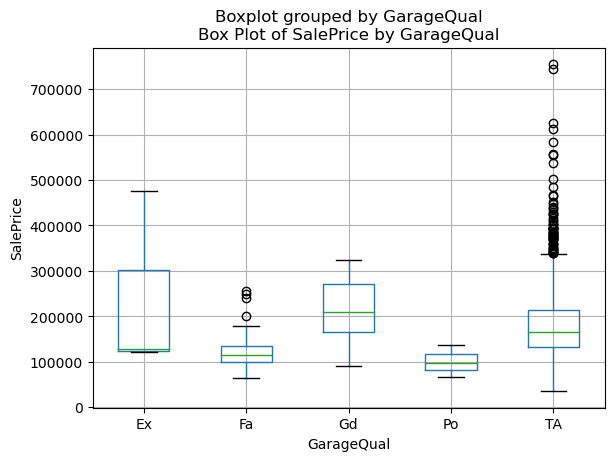

<Figure size 800x600 with 0 Axes>

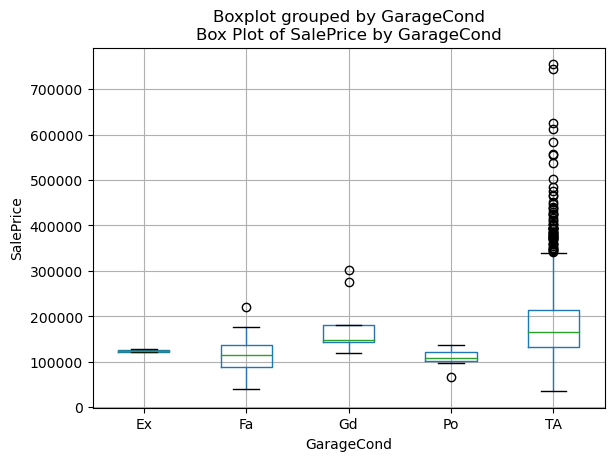

<Figure size 800x600 with 0 Axes>

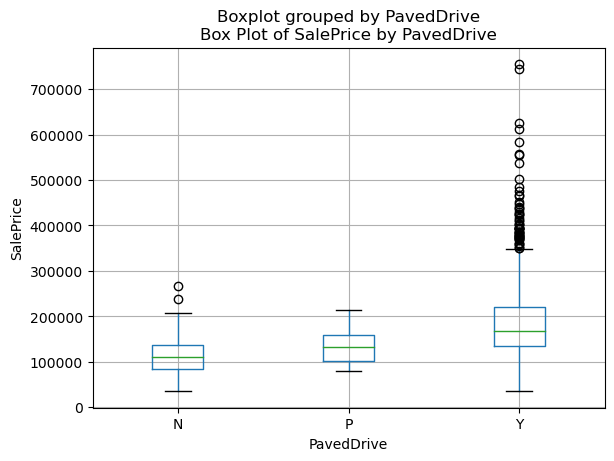

<Figure size 800x600 with 0 Axes>

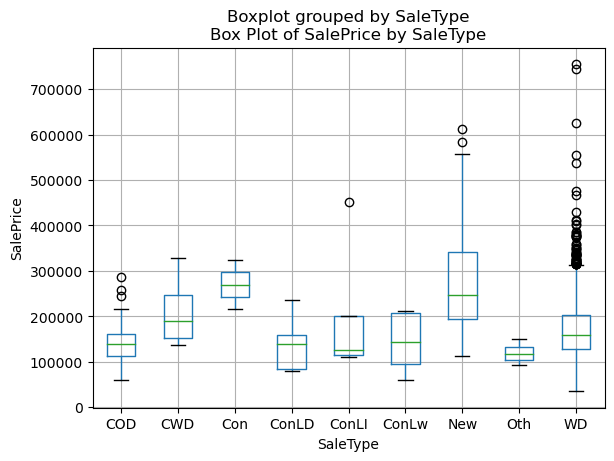

<Figure size 800x600 with 0 Axes>

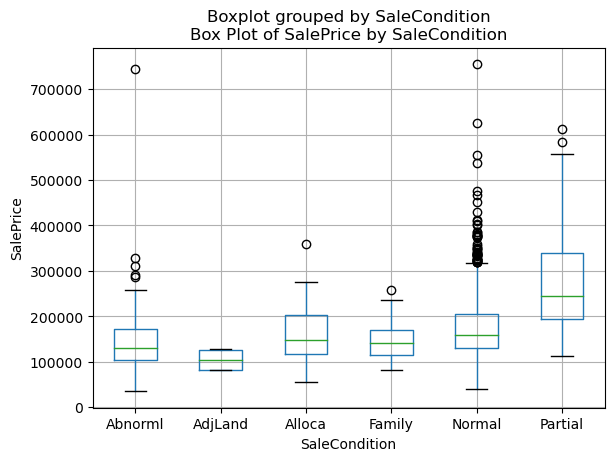

In [17]:
# Create a box plot for each categorical column against SalePrice
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    housing.boxplot(column='SalePrice', by=col)
    plt.title(f'Box Plot of SalePrice by {col}')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

# Data Preparation

In [18]:
# split into X and y
X = housing.drop('SalePrice', axis=1) # predictors in variable X

y = housing['SalePrice'] # response variable in Y

In [19]:
# creating dummy variables for categorical variables

# subset all categorical variables
housing_categorical = X.select_dtypes(include=['object'])
housing_categorical.head()

# convert into dummies - one hot encoding
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)
housing_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 227 entries, MSSubClass_30 to SaleCondition_Partial
dtypes: uint8(227)
memory usage: 323.8 KB


In [20]:
# drop categorical variables 
X = X.drop(list(categorical_columns), axis=1)

In [21]:
# concat dummy variables with X
X = pd.concat([X, housing_dummies], axis=1)

In [22]:
X.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0         65.0     8450       2003          2003       196.0         706   
1         80.0     9600       1976          1976         0.0         978   
2         68.0    11250       2001          2002       162.0         486   
3         60.0     9550       1915          1970         0.0         216   
4         84.0    14260       2000          2000       350.0         655   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  \
0           0        150          856       856  ...               0   
1           0        284         1262      1262  ...               0   
2           0        434          920       920  ...               0   
3           0        540          756       961  ...               0   
4           0        490         1145      1145  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 260 columns]

In [23]:
# scaling the features - necessary before using linear regression
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=260)

In [24]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

# Model Building and Evaluation

### Linear Regression
Let's now try predicting car prices, a dataset using linear regression.

In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Create a regression model (e.g., Linear Regression)
model = LinearRegression()

# Fit a line
model.fit(X_train, y_train)

# Print the coefficients and intercept
print(model.intercept_)
print(model.coef_)

-248567410066269.34
[ 2.12083313e+03  6.63622043e+03  1.33271595e+04  2.06081964e+03
  2.82340731e+03  7.75528430e+15  2.74299947e+15  7.51330455e+15
 -7.45954562e+15 -6.81479727e+15 -7.69515559e+15 -8.57131279e+14
  9.26320710e+15  7.24687500e+02 -2.05125000e+02  1.21064062e+03
 -1.53612500e+03 -1.79412500e+03 -3.56275000e+03 -1.17475000e+03
  1.02750000e+03  1.47000000e+03  2.29675000e+03  1.86562500e+03
  5.68375000e+02  1.93125000e+03  5.66437500e+02  1.30600000e+03
  1.35500000e+03  3.50362500e+03  5.73000000e+02 -7.80031250e+02
 -4.05656250e+02  5.00375000e+02  3.91562500e+02 -8.39750000e+02
 -1.26912500e+03  1.38918750e+03  8.93750000e+02 -3.78837500e+03
 -8.74187500e+02 -1.15187500e+03 -1.47714060e+15 -2.45250000e+02
 -5.26500000e+02 -2.30937500e+02  5.94638969e+15  8.24600000e+03
  4.40531250e+03  1.73585000e+04  1.32320000e+04  1.56643750e+03
  3.00500000e+02  3.21812500e+02  3.83656250e+02 -9.07500000e+01
 -6.18000000e+02  1.16925000e+03 -3.36718750e+02  1.93025000e+03
 -1.0

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("Train Dataset: R-squared (R2) Score:", r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("Test Dataset: R-squared (R2) Score:", r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("Train Dataset: Residual Sum of Squares",rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("Test Dataset: Residual Sum of Squares", rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("Train Dataset: Mean Squared Error", mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("Test Dataset: Mean Squared Error", mse_test_lr)
metric.append(mse_test_lr**0.5)



Train Dataset: R-squared (R2) Score: 0.956200250358879
Test Dataset: R-squared (R2) Score: -3.24012340043665e+22
Train Dataset: Residual Sum of Squares 279473009952.4971
Test Dataset: Residual Sum of Squares 9.132976428692072e+34
Train Dataset: Mean Squared Error 273724789.3756093
Test Dataset: Mean Squared Error 2.0851544357744457e+32



# Ridge and Lasso Regression
Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

In [27]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 550, 600, 700, 800, 1000, 1500, 2000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 34 candidates, totalling 170 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 550, 600, 700, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [28]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [29]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
#print(ridge.coef_)

Ridge(alpha=500)

In [30]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("Train Dataset: R-squared (R2) Score:", r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("Test Dataset: R-squared (R2) Score:", r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("Train Dataset: Residual Sum of Squares",rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("Test Dataset: Residual Sum of Squares", rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("Train Dataset: Mean Squared Error", mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("Test Dataset: Mean Squared Error", mse_test_lr)
metric2.append(mse_test_lr**0.5)

Train Dataset: R-squared (R2) Score: 0.8935452366344708
Test Dataset: R-squared (R2) Score: 0.863047332953581
Train Dataset: Residual Sum of Squares 679255780805.0475
Test Dataset: Residual Sum of Squares 386030198668.6364
Train Dataset: Mean Squared Error 665284800.0049436
Test Dataset: Mean Squared Error 881347485.544832


# Lasso

In [31]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv =                        folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 34 candidates, totalling 170 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 550, 600, 700, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [32]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [33]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [34]:
#lasso.coef_

In [35]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("Train Dataset: R-squared (R2) Score:", r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("Test Dataset: R-squared (R2) Score:", r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("Train Dataset: Residual Sum of Squares",rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("Test Dataset: Residual Sum of Squares", rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("Train Dataset: Mean Squared Error", mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("Test Dataset: Mean Squared Error", mse_test_lr)
metric3.append(mse_test_lr**0.5)

Train Dataset: R-squared (R2) Score: 0.9325195051489572
Test Dataset: R-squared (R2) Score: 0.8468941119972874
Train Dataset: Residual Sum of Squares 430572712484.1671
Test Dataset: Residual Sum of Squares 431561484983.6587
Train Dataset: Mean Squared Error 421716662.57019305
Test Dataset: Mean Squared Error 985300194.026618


In [36]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.562003e-01      8.935452e-01      9.325195e-01
1   R2 Score (Test)      -3.240123e+22      8.630473e-01      8.468941e-01
2       RSS (Train)       2.794730e+11      6.792558e+11      4.305727e+11
3        RSS (Test)       9.132976e+34      3.860302e+11      4.315615e+11
4       MSE (Train)       1.654463e+04      2.579312e+04      2.053574e+04
5        MSE (Test)       1.444006e+16      2.968750e+04      3.138949e+04

#### Lets observe the changes in the coefficients after regularization

In [37]:
betas = pd.DataFrame(index=X.columns)

betas.rows = X.columns

betas['Linear'] = model.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
#sorted_betas_ridge = betas.head(68).sort_values(by='Ridge', ascending=False)
sorted_betas_lasso = betas.head(68).sort_values(by='Lasso', ascending=False)

#print(sorted_betas_ridge)
print(sorted_betas_lasso)

                            Linear        Ridge         Lasso
GrLivArea             9.263207e+15  7760.922460  30484.355173
YearBuilt             1.332716e+04  1951.303548   8467.075532
GarageCars            2.296750e+03  4403.886261   5574.581680
LotArea               6.636220e+03  2717.001562   3958.389246
YearRemodAdd          2.060820e+03  3065.019532   3764.690702
TotalBsmtSF          -7.459546e+15  3431.977022   3319.102151
BsmtFullBath          7.246875e+02  2387.711488   2829.417324
FullBath              1.210641e+03  4185.732777   2339.775133
BsmtFinSF1            7.755284e+15  2132.484907   2140.315000
Fireplaces            1.027500e+03  3788.887837   2001.115577
LotConfig_CulDSac     1.930250e+03  2008.220703   1889.872578
MasVnrArea            2.823407e+03  3346.898076   1517.136719
MSZoning_RL           1.735850e+04  1221.644987   1317.214703
ScreenPorch           1.355000e+03  1391.436497   1096.442564
LandContour_Lvl       1.169250e+03  1537.247001   1092.052035
3SsnPorc

# After building the model, you realized that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?


In [38]:
#exclude top 5 variables from train & test datasets

X_new = X.drop(['GrLivArea','GarageCars','YearRemodAdd','YearBuilt','Fireplaces'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size=0.7, test_size = 0.3, random_state=100)


In [39]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv =                        folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 34 candidates, totalling 170 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 550, 600, 700, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [40]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [41]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [43]:
# Display cofficent after re-modeling

newbetas.rows = X_train.columns

newbetas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
sorted_betas_lasso = newbetas.head(68).sort_values(by='Lasso', ascending=False)

print(sorted_betas_lasso)

                             Lasso
2ndFlrSF              24538.350574
1stFlrSF              21132.762068
Neighborhood_Crawfor   4147.443903
GarageArea             4102.309264
FullBath               3695.400313
LotArea                3650.482273
TotalBsmtSF            3603.978022
BsmtFullBath           2707.117223
BsmtFinSF1             2264.976342
LotConfig_CulDSac      2032.815820
MasVnrArea             1857.346267
MSZoning_RL            1647.443730
GarageYrBlt            1361.404062
ScreenPorch            1231.535236
LandContour_Lvl        1229.819067
Neighborhood_ClearCr   1184.931554
3SsnPorch              1028.691289
HalfBath                756.569582
Street_Pave             514.824999
WoodDeckSF              460.463104
LotShape_IR2            364.627751
Neighborhood_Gilbert    298.237804
OpenPorchSF             144.963194
BsmtHalfBath             37.901388
LandSlope_Sev            -0.000000
LotShape_Reg             -0.000000
MSZoning_RH               0.000000
Neighborhood_CollgCr

### the five most important predictor variables now are as below

- 2ndFlrSF
- 1stFlrSF
- KitchenAbvGr
- Neighborhood_Crawfor
- GarageArea

# Conclusion
- Ridge Model will be the best fit model for predicting housing pricess.  